In [1]:
import pandas as pd
import numpy as np

In [2]:
from scipy.stats import beta as beta_dist

ModuleNotFoundError: No module named 'scipy'

In [ ]:
!pip install --upgrade pydata-google-auth google-cloud-bigquery[pandas] pandas-gbq

In [26]:
import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

# SQL formula

In [33]:
query = """
with installment_number as (
 select ii.id, ii.invoice_id,
    row_number() over(partition by ii.invoice_id order by ii.settlement_date asc) as numero_da_parcela,
from `core-db-prd-255.core_db_prd_raw.invoice_installments` ii
group by 1, ii.settlement_date,ii.invoice_id
order by 2
)
,
numero as(
  select invoice_id,
max(numero_da_parcela) as numero_de_parcelas
from installment_number inu
group by invoice_id
)

select cp.*,
  case 
    when nu.numero_de_parcelas >1 then (case 
      when inu.numero_da_parcela = 1 then "1- first_installment"
      when inu.numero_da_parcela = nu.numero_de_parcelas then "3- last_installment"
      else "2- middle_installment"
      end)
  else "1- first_installment"
  end as installment_number,
  numero_de_parcelas,
  numero_da_parcela as installment_numero
  -- CONCAT(CAST(invoice_id as STRING),CAST(inu.r as STRING)) as unique_key
  ,inu.invoice_id
, case when sum(payment_amount) over (PARTITION BY company_id order by dt_ref) > 10 then 'True' else 'False' end as Paid_previous
, case when sum(payment_amount) over (PARTITION BY company_id order by dt_ref)>sum(tpv) over (PARTITION BY company_id order by dt_ref)  then 'True' else 'False' end as Adimplente
from  core_db_prd_raw.vw_credit_portfolio as cp
left join installment_number as inu on inu.id=cp.installment_id
left join numero nu on nu.invoice_id = inu.invoice_id
-- where inu.r = 2
group by inu.numero_da_parcela,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18 ,inu.invoice_id,nu.numero_de_parcelas 
""" 
project_id = 'core-db-prd-255'

pagadores = """
select dt_ref, company_id,installment_id,
sum(payment_amount) over (PARTITION BY company_id order by dt_ref) as running_total
, CONCAT(CAST(dt_ref AS string), company_id) as unique_key
from core_db_prd_raw.vw_credit_portfolio

group by 1,payment_amount,installment_settlement_date,2
order by 1
""" 
project_id = 'core-db-prd-255'

In [34]:
import pandas as pd
credit_portfolio = pd.read_gbq(query, project_id=project_id, dialect='standard', credentials=credentials)



In [6]:
credit_portfolio

,dt_ref,company_id,document_number,company_created_at,dt_credit_approval,days_on_book,days_on_book_cohort_cut,installment_id,seller_name,invoice_approved_at,...,payment_amount,cum_payment_amount,outstanding_balance,tpv,installment_number,numero_de_parcelas,installment_numero,invoice_id,Paid_previous,Adimplente
0,2022-02-16,019e174f-b174-4085-8741-f8a04401fb35,43728418000122,2022-02-11,2022-02-16,0,90,677c596a-9af7-419b-bedc-690fea01b141,Inventa App Ltda,2022-02-16,...,0.0,0.00,549.54,549.54,1- first_installment,3,1,9f477cb3-9825-4b37-be0a-7ca657a72bf2,False,False
1,2022-02-16,019e174f-b174-4085-8741-f8a04401fb35,43728418000122,2022-02-11,2022-02-16,0,90,aa31158d-1191-450b-bd74-b04484e5e189,Inventa App Ltda,2022-02-16,...,0.0,0.00,549.53,549.53,3- last_installment,3,3,9f477cb3-9825-4b37-be0a-7ca657a72bf2,False,False
2,2022-02-16,019e174f-b174-4085-8741-f8a04401fb35,43728418000122,2022-02-11,2022-02-16,0,90,47fac850-0959-4376-badb-2349f51c06c0,Inventa App Ltda,2022-02-16,...,0.0,0.00,549.53,549.53,2- middle_installment,3,2,9f477cb3-9825-4b37-be0a-7ca657a72bf2,False,False
3,2022-02-17,019e174f-b174-4085-8741-f8a04401fb35,43728418000122,2022-02-11,2022-02-16,1,89,677c596a-9af7-419b-bedc-690fea01b141,Inventa App Ltda,2022-02-16,...,0.0,0.00,549.54,0.00,1- first_installment,3,1,9f477cb3-9825-4b37-be0a-7ca657a72bf2,False,False
4,2022-02-17,019e174f-b174-4085-8741-f8a04401fb35,43728418000122,2022-02-11,2022-02-16,1,89,aa31158d-1191-450b-bd74-b04484e5e189,Inventa App Ltda,2022-02-16,...,0.0,0.00,549.53,0.00,3- last_installment,3,3,9f477cb3-9825-4b37-be0a-7ca657a72bf2,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597644,2022-05-02,fc87085c-dc8a-42eb-a245-84509f9d7690,42517442000150,2021-11-09,2021-11-10,173,9,2aef76c3-e927-489d-9e3b-9658afb767e7,Hydronorth S/A,2022-04-12,...,0.0,0.00,784.96,0.00,3- last_installment,3,3,996fa11a-1a59-4460-a531-a56d19033365,True,False
597645,2022-05-02,fc87085c-dc8a-42eb-a245-84509f9d7690,42517442000150,2021-11-09,2021-11-10,173,9,88d1463f-714e-4277-8f32-06c3b0f0c6e2,Hydronorth S/A,2021-12-08,...,0.0,887.25,0.00,0.00,1- first_installment,3,1,2b403727-6db0-4a57-a2a0-2ba045da1ceb,True,False
597646,2022-05-02,fc87085c-dc8a-42eb-a245-84509f9d7690,42517442000150,2021-11-09,2021-11-10,173,9,99630229-646b-4dff-8564-98bfb5c0f508,Hydronorth S/A,2022-02-16,...,0.0,639.36,958.97,0.00,3- last_installment,3,3,22f009e9-bd89-4e3e-bea3-c423f77fe496,True,False
597647,2022-05-02,fc87085c-dc8a-42eb-a245-84509f9d7690,42517442000150,2021-11-09,2021-11-10,173,9,0cd8228d-a862-48a4-a498-fc8c967a0958,Hydronorth S/A,2021-11-10,...,0.0,563.26,0.00,0.00,2- middle_installment,5,3,02c6a0e3-9b2b-4742-af32-df870453069a,True,False


pagadores = pd.read_gbq(pagadores, project_id=project_id, dialect='standard', credentials=credentials)
pagadores

#After installing gcp-common-scripts (https://github.com/truepay/gcp-common-scripts)
#!source select-user-account
#!source select-project core-db-prd

#After installing  google-cloud-bigquery (pip install google-cloud-bigquery)
#%load_ext google.cloud.bigquery

#%%bigquery credit_portfolio
#with installment_number as (
 #select ii.id, ii.invoice_id,
 #row_number() over(partition by ii.invoice_id order by ii.settlement_date asc) as installment_number,
#from `core-db-prd-255.core_db_prd_raw.invoice_installments` ii
#group by 1, ii.settlement_date,ii.invoice_id
#order by 2
#)
#select cp.*,inu.installment_number, inu.invoice_id
#from  core_db_prd_raw.vw_credit_portfolio as cp
#left join installment_number as inu on inu.id=cp.installment_id

credit_portfolio = pd.merge(credit_portfolio, pagadores,  how='left', on=['dt_ref','installment_id'])


credit_portfolio

In [7]:
def payed_installment(df_installment):
    return np.any(df_installment["already_payed"])


### Creating payment flags

In [8]:
all_installments = credit_portfolio[
    credit_portfolio["installment_settlement_date"].astype(np.datetime64) <= 
    (np.datetime64("now") - np.timedelta64(60, 'D'))
].copy()

all_installments["already_payed"] = all_installments["cum_payment_amount"] >= (all_installments["installment_amount"] * 0.98)
payed_installments = all_installments.groupby("installment_id").apply(payed_installment).reset_index().rename(columns={0:"eventually_payed"})
df = all_installments.merge(payed_installments, on="installment_id")


### Creating discretized features

In [9]:
df["is_tintas"] = df["seller_name"] != 'Inventa App Ltda'
df["Paid_previously"] = df["Paid_previous"] != 'False'
df["range_days_since_due_date"] = pd.cut(
    df["days_since_due_date"], 
    bins=[-1, 0, 15, 30, 60, np.inf]
)
df["range_de_valor"] = pd.cut(
    df["installment_amount"], 
    bins=[0, 500,1500,  np.inf]
)

In [10]:
df_not_payed_yet = df[~df["already_payed"]]

In [11]:
def create_payment_percentage(df_installments):
    df_unique_installments = df_installments.drop_duplicates("installment_id")
    return round(np.mean(df_unique_installments["eventually_payed"])*100,2)

def create_payment_lower_interval(df_installments):
    df_unique_installments = df_installments.drop_duplicates("installment_id")
    alpha = np.sum(df_unique_installments["eventually_payed"].astype(int)) + 1
    beta = df_unique_installments["eventually_payed"].shape[0] - np.sum(df_unique_installments["eventually_payed"].astype(int)) + 1
    return beta_dist.ppf(.05, alpha, beta)

def create_payment_higher_interval(df_installments):
    df_unique_installments = df_installments.drop_duplicates("installment_id")
    alpha = np.sum(df_unique_installments["eventually_payed"].astype(int)) + 1
    beta = df_unique_installments["eventually_payed"].shape[0] - np.sum(df_unique_installments["eventually_payed"].astype(int)) + 1
    return beta_dist.ppf(.95, alpha, beta)

def create_payment_count(df_installments):
    df_unique_installments = df_installments.drop_duplicates("installment_id")
    return df_unique_installments["eventually_payed"].shape[0]

dict_variables = ["is_tintas", "installment_number","range_de_valor","Paid_previous", "range_days_since_due_date"]

payment_behaviour = df_not_payed_yet.groupby(dict_variables).apply(create_payment_percentage).unstack()
payment_behaviour_min = df_not_payed_yet.groupby(dict_variables).apply(create_payment_lower_interval).unstack()
payment_behaviour_max = df_not_payed_yet.groupby(dict_variables).apply(create_payment_higher_interval).unstack()
payment_counts = df_not_payed_yet.groupby(dict_variables).apply(create_payment_count).unstack()

In [12]:
payment_behaviour

range_days_since_due_date                                      (-1.0, 0.0]  \
is_tintas installment_number    range_de_valor  Paid_previous                
False     1- first_installment  (0.0, 500.0]    False                11.26   
                                                True                 45.45   
                                (500.0, 1500.0] False                 5.75   
                                                True                 33.33   
                                (1500.0, inf]   False                13.33   
                                                True                  0.00   
          2- middle_installment (0.0, 500.0]    False                 5.65   
                                                True                 35.71   
                                (500.0, 1500.0] False                 3.52   
                                                True                 36.84   
                                (1500.0, inf]   False                14.29   
                                                True                 50.00   
          3- last_installment   (0.0, 500.0]    False                 4.59   
                                                True                 22.50   
                                (500.0, 1500.0] False                 3.12   
                                                True                 26.32   
                                (1500.0, inf]   False                 9.09   
                                                True                 33.33   
True      1- first_installment  (0.0, 500.0]    False                66.67   
                                                True                 96.77   
                                (500.0, 1500.0] False                60.94   
                                                True                 85.71   
                                (1500.0, inf]   False                36.36   
                                                True                 57.14   
          2- middle_installment (0.0, 500.0]    False                66.67   
                                                True                 37.74   
                                (500.0, 1500.0] False                66.67   
                                                True                 70.31   
                                (1500.0, inf]   False                30.77   
                                                True                 50.00   
          3- last_installment   (0.0, 500.0]    False                60.87   
                                                True                 36.84   
                                (500.0, 1500.0] False                56.67   
                                                True                 61.76   
                                (1500.0, inf]   False                35.00   
                                                True                 50.00   

range_days_since_due_date                                      (0.0, 15.0]  \
is_tintas installment_number    range_de_valor  Paid_previous                
False     1- first_installment  (0.0, 500.0]    False                 4.79   
                                                True                 30.00   
                                (500.0, 1500.0] False                 2.59   
                                                True                 25.00   
                                (1500.0, inf]   False                 7.69   
                                                True                 25.00   
          2- middle_installment (0.0, 500.0]    False                 0.40   
                                                True                 24.32   
                                (500.0, 1500.0] False                 0.00   
                                                True                 35.00   
                                (1500.0, inf]   False                 0.00   
                     

# Heatmap

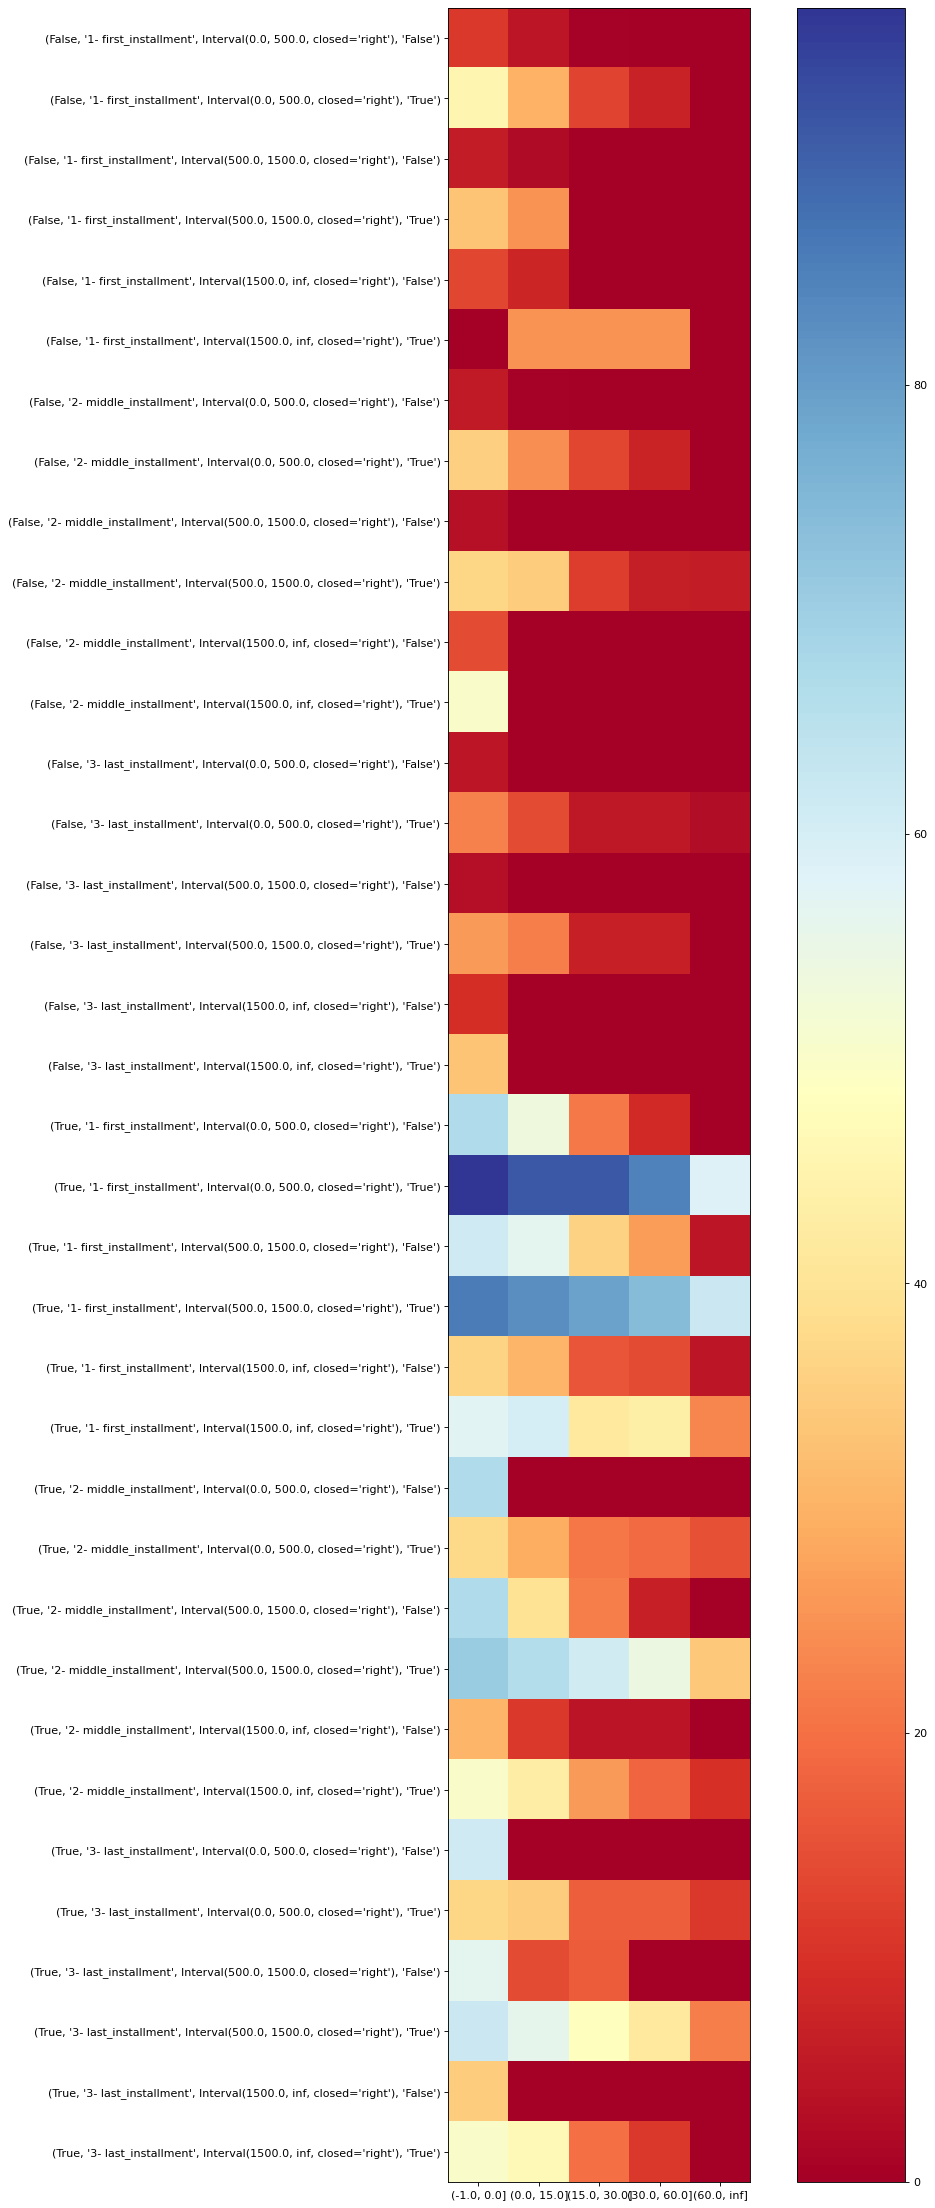

In [13]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15, 36), dpi=80)

plt.imshow(payment_behaviour, cmap ="RdYlBu")
plt.colorbar()
  

plt.xticks(range(5), payment_behaviour.columns)

plt.yticks(range(len(payment_behaviour)), payment_behaviour.index)
#plt.savefig('books_read.pdf')
plt.show()


In [14]:
payment_behaviour_min

range_days_since_due_date                                      (-1.0, 0.0]  \
is_tintas installment_number    range_de_valor  Paid_previous                
False     1- first_installment  (0.0, 500.0]    False             0.091880   
                                                True              0.337945   
                                (500.0, 1500.0] False             0.041040   
                                                True              0.150028   
                                (1500.0, inf]   False             0.053146   
                                                True              0.012741   
          2- middle_installment (0.0, 500.0]    False             0.038496   
                                                True              0.249183   
                                (500.0, 1500.0] False             0.020745   
                                                True              0.217069   
                                (1500.0, inf]   False             0.046389   
                                                True              0.135350   
          3- last_installment   (0.0, 500.0]    False             0.027795   
                                                True              0.138719   
                                (500.0, 1500.0] False             0.016352   
                                                True              0.139554   
                                (1500.0, inf]   False             0.030460   
                                                True              0.097611   
True      1- first_installment  (0.0, 500.0]    False             0.538680   
                                                True              0.860151   
                                (500.0, 1500.0] False             0.505965   
                                                True              0.684087   
                                (1500.0, inf]   False             0.256944   
                                                True              0.289241   
          2- middle_installment (0.0, 500.0]    False             0.496358   
                                                True              0.277426   
                                (500.0, 1500.0] False             0.565341   
                                                True              0.601230   
                                (1500.0, inf]   False             0.215761   
                                                True              0.352005   
          3- last_installment   (0.0, 500.0]    False             0.437107   
                                                True              0.254143   
                                (500.0, 1500.0] False             0.417973   
                                                True              0.475596   
                                (1500.0, inf]   False             0.205750   
                                                True              0.310830   

range_days_since_due_date                                      (0.0, 15.0]  \
is_tintas installment_number    range_de_valor  Paid_previous                
False     1- first_installment  (0.0, 500.0]    False             0.034410   
                                                True              0.198829   
                                (500.0, 1500.0] False             0.015626   
                                                True              0.112666   
                                (1500.0, inf]   False             0.025999   
                                                True              0.076440   
          2- middle_installment (0.0, 500.0]    False             0.001435   
                                                True              0.150282   
                                (500.0, 1500.0] False             0.000245   
                                                True              0.205750   
                                (1500.0, inf]   False             0.007301   
                     

In [15]:
payment_behaviour_max

range_days_since_due_date                                      (-1.0, 0.0]  \
is_tintas installment_number    range_de_valor  Paid_previous                
False     1- first_installment  (0.0, 500.0]    False             0.138194   
                                                True              0.577272   
                                (500.0, 1500.0] False             0.081576   
                                                True              0.606624   
                                (1500.0, inf]   False             0.343825   
                                                True              0.527129   
          2- middle_installment (0.0, 500.0]    False             0.084313   
                                                True              0.485219   
                                (500.0, 1500.0] False             0.062418   
                                                True              0.558035   
                                (1500.0, inf]   False             0.470679   
                                                True              0.864650   
          3- last_installment   (0.0, 500.0]    False             0.078366   
                                                True              0.351799   
                                (500.0, 1500.0] False             0.064185   
                                                True              0.455582   
                                (1500.0, inf]   False             0.338681   
                                                True              0.751395   
True      1- first_installment  (0.0, 500.0]    False             0.771186   
                                                True              0.988781   
                                (500.0, 1500.0] False             0.702473   
                                                True              0.935404   
                                (1500.0, inf]   False             0.488706   
                                                True              0.807097   
          2- middle_installment (0.0, 500.0]    False             0.797622   
                                                True              0.491143   
                                (500.0, 1500.0] False             0.752738   
                                                True              0.785872   
                                (1500.0, inf]   False             0.421739   
                                                True              0.647995   
          3- last_installment   (0.0, 500.0]    False             0.753611   
                                                True              0.503055   
                                (500.0, 1500.0] False             0.702513   
                                                True              0.739508   
                                (1500.0, inf]   False             0.535936   
                                                True              0.689170   

range_days_since_due_date                                      (0.0, 15.0]  \
is_tintas installment_number    range_de_valor  Paid_previous                
False     1- first_installment  (0.0, 500.0]    False             0.067591   
                                                True              0.430652   
                                (500.0, 1500.0] False             0.044569   
                                                True              0.494650   
                                (1500.0, inf]   False             0.296734   
                                                True              0.657408   
          2- middle_installment (0.0, 500.0]    False             0.018985   
                                                True              0.376906   
                                (500.0, 1500.0] False             0.014231   
                                                True              0.535936   
                                (1500.0, inf]   False             0.348164   
                     

In [16]:
payment_counts

range_days_since_due_date                                      (-1.0, 0.0]  \
is_tintas installment_number    range_de_valor  Paid_previous                
False     1- first_installment  (0.0, 500.0]    False                  506   
                                                True                    44   
                                (500.0, 1500.0] False                  365   
                                                True                     9   
                                (1500.0, inf]   False                   15   
                                                True                     3   
          2- middle_installment (0.0, 500.0]    False                  283   
                                                True                    42   
                                (500.0, 1500.0] False                  227   
                                                True                    19   
                                (1500.0, inf]   False                    7   
                                                True                     2   
          3- last_installment   (0.0, 500.0]    False                  196   
                                                True                    40   
                                (500.0, 1500.0] False                  160   
                                                True                    19   
                                (1500.0, inf]   False                   11   
                                                True                     3   
True      1- first_installment  (0.0, 500.0]    False                   42   
                                                True                    31   
                                (500.0, 1500.0] False                   64   
                                                True                    21   
                                (1500.0, inf]   False                   44   
                                                True                     7   
          2- middle_installment (0.0, 500.0]    False                   24   
                                                True                    53   
                                (500.0, 1500.0] False                   66   
                                                True                    64   
                                (1500.0, inf]   False                   52   
                                                True                    28   
          3- last_installment   (0.0, 500.0]    False                   23   
                                                True                    38   
                                (500.0, 1500.0] False                   30   
                                                True                    34   
                                (1500.0, inf]   False                   20   
                                                True                    16   

range_days_since_due_date                                      (0.0, 15.0]  \
is_tintas installment_number    range_de_valor  Paid_previous                
False     1- first_installment  (0.0, 500.0]    False                  459   
                                                True                    40   
                                (500.0, 1500.0] False                  348   
                                                True                    12   
                                (1500.0, inf]   False                   13   
                                                True                     4   
          2- middle_installment (0.0, 500.0]    False                  247   
                                                True                    37   
                                (500.0, 1500.0] False                  208   
                                                True                    20   
                                (1500.0, inf]   False                    6   
                     